## Desenvolvimento de um modelo para o serviço de vendas de carros usados Para empresa **Rusty Bargain**, com o objetivo de estimar rapidamente o valor de mercado de veículos. O modelo foi projetado para determinar de forma precisa e eficiente o preço justo de cada carro, otimizando o processo de compra e venda.

Rusty Bargain está interessado em:

- a qualidade da predição;
- a velocidade da predição;
- o tempo necessário para o treinamento

# Dicionario dos dados

- DateCrawled — data em que o perfil foi baixado do banco de dados

- VehicleType — tipo de carroçaria do veículo

- RegistrationYear — ano de matrícula do veículo

- Gearbox — tipo de caixa de transmissão

- Power — potência (hp)

- Model — modelo do veículo

- Mileage — quilometragem (medida em km devido às especificidades regionais do conjunto de dados)

- RegistrationMonth — mês de registro do veículo

- FuelType — tipo de combustível

- Brand — marca do veículo

- NotRepaired — veículo reparado ou não

- DateCreated — data de criação do perfil

- NumberOfPictures — número de fotos do veículo

- PostalCode — código postal do proprietário do perfil (usuário)

- LastSeen — data da última atividade do usuário

## Preparação de Dados

### Importando biliotecas

In [ ]:
!pip install --upgrade lightgbm -q
!pip install --upgrade scikit-learn -q
!pip install --upgrade -U matplotlib -q
!pip install catboost -q
!pip install category_encoders -q # categorias



In [2]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import sklearn.preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import time
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
import time
import category_encoders as ce

### Verificando os dados

In [3]:
df = pd.read_csv('car_data.csv')

### transformar dataset em letra minuscula

In [4]:
df.columns = df.columns.str.lower()
df.sample(7)

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
156556,14/03/2016 20:48,4450,NaN,2018,manual,90,corsa,125000,4,petrol,opel,no,14/03/2016 00:00,0,53783,06/04/2016 04:15
257747,04/04/2016 20:46,750,wagon,1998,manual,136,omega,150000,6,petrol,opel,yes,04/04/2016 00:00,0,32758,06/04/2016 23:16
126044,16/03/2016 12:54,400,small,2001,auto,80,punto,125000,5,petrol,fiat,NaN,16/03/2016 00:00,0,58239,16/03/2016 13:40
278743,08/03/2016 00:55,1199,small,1999,manual,75,golf,150000,1,other,volkswagen,NaN,07/03/2016 00:00,0,42327,10/03/2016 06:15
12811,20/03/2016 12:46,2300,other,1999,manual,102,other,150000,4,gasoline,volkswagen,no,20/03/2016 00:00,0,14822,20/03/2016 12:46
144810,04/04/2016 18:41,9690,wagon,2008,manual,170,3er,150000,6,petrol,bmw,no,04/04/2016 00:00,0,80999,06/04/2016 20:44
166179,05/03/2016 14:46,600,small,2001,manual,75,other,150000,9,petrol,citroen,no,05/03/2016 00:00,0,57334,27/03/2016 13:47


### Descrição dos dados

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
registrationyear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
mileage,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
registrationmonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
numberofpictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
postalcode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


Em uma análise rápida, conseguimos ver que existem dados estranhos como veículos com 

- Price igual a zero, 

- Registrationyear como 1000,

- Power igual zero, 

- Registrationmonth igual zero.

Não foi observado foto de veiculos pode ser desconsiderada essa coluna

#### Verificando todos os dados da coluna

In [6]:
df['numberofpictures'].unique()

array([0], dtype=int64)

#### Retirando a coluna numberofpictures

In [7]:
df = df.drop('numberofpictures', axis=1)
df.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,datecreated,postalcode,lastseen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,60437,06/04/2016 10:17


### Informação dos dados

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354369 non-null  object
 1   price              354369 non-null  int64 
 2   vehicletype        316879 non-null  object
 3   registrationyear   354369 non-null  int64 
 4   gearbox            334536 non-null  object
 5   power              354369 non-null  int64 
 6   model              334664 non-null  object
 7   mileage            354369 non-null  int64 
 8   registrationmonth  354369 non-null  int64 
 9   fueltype           321474 non-null  object
 10  brand              354369 non-null  object
 11  notrepaired        283215 non-null  object
 12  datecreated        354369 non-null  object
 13  postalcode         354369 non-null  int64 
 14  lastseen           354369 non-null  object
dtypes: int64(6), object(9)
memory usage: 40.6+ MB


### verificação de dados ausentes

In [9]:
df[['datecrawled','price','vehicletype','registrationyear','gearbox', 'power', 'model',
    'mileage', 'registrationmonth', 'registrationmonth','fueltype', 'brand', 'notrepaired',
    'datecreated', 'postalcode', 'lastseen']].isna().sum()

datecrawled              0
price                    0
vehicletype          37490
registrationyear         0
gearbox              19833
power                    0
model                19705
mileage                  0
registrationmonth        0
registrationmonth        0
fueltype             32895
brand                    0
notrepaired          71154
datecreated              0
postalcode               0
lastseen                 0
dtype: int64

Existem dados ausentes nas colunas: 

- vehicletype,

- gearbox,

- model,

- fueltype,

- notrepaired.

Vamos verificar cada uma das colunas para poder ver o melhortratamento para cada caso.

### Tratamento dos dados

#### Coluna VehicleType


In [10]:
df['vehicletype'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

#### Verificando os dados ausetes da coluna 

In [11]:

df[df['vehicletype'].isna()]

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,datecreated,postalcode,lastseen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,70435,07/04/2016 03:16
16,01/04/2016 12:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,01/04/2016 00:00,38871,01/04/2016 12:46
22,23/03/2016 14:52,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,23/03/2016 00:00,49716,31/03/2016 01:16
26,10/03/2016 19:38,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,10/03/2016 00:00,31139,16/03/2016 09:16
31,29/03/2016 16:57,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,NaN,29/03/2016 00:00,37075,29/03/2016 17:43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354346,07/03/2016 17:06,2600,NaN,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,NaN,07/03/2016 00:00,61169,08/03/2016 21:28
354351,11/03/2016 23:40,1900,NaN,2000,manual,110,NaN,150000,7,NaN,volkswagen,no,11/03/2016 00:00,87700,12/03/2016 14:16
354361,09/03/2016 13:37,5250,NaN,2016,auto,150,159,150000,12,NaN,alfa_romeo,no,09/03/2016 00:00,51371,13/03/2016 01:44
354364,21/03/2016 09:50,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,21/03/2016 00:00,2694,21/03/2016 10:42


#### Peso do dados ausentes vehicletype

In [12]:
(df['vehicletype'].isna().sum()/len(df))*100

10.57936783409384

Verificado que 10% dos dados da coluna vehicletype esta ausente

#### Coluna Gearbox

In [13]:
df['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

#### Verificando os dados ausetes da coluna 

In [14]:
df[df['gearbox'].isna()]

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,datecreated,postalcode,lastseen
15,11/03/2016 21:39,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,11/03/2016 00:00,24148,19/03/2016 08:46
16,01/04/2016 12:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,01/04/2016 00:00,38871,01/04/2016 12:46
32,15/03/2016 20:59,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,15/03/2016 00:00,44145,17/03/2016 18:17
37,28/03/2016 17:50,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,28/03/2016 00:00,46483,30/03/2016 09:18
40,26/03/2016 22:06,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,26/03/2016 00:00,56412,27/03/2016 17:43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354288,16/03/2016 13:36,3300,wagon,2006,NaN,0,touran,150000,7,gasoline,volkswagen,NaN,16/03/2016 00:00,12057,17/03/2016 12:17
354305,03/04/2016 13:46,3500,NaN,1995,NaN,0,polo,150000,0,NaN,volkswagen,NaN,03/04/2016 00:00,74579,05/04/2016 12:44
354329,30/03/2016 20:55,350,small,1996,NaN,65,punto,150000,0,NaN,fiat,NaN,30/03/2016 00:00,25436,07/04/2016 13:50
354338,31/03/2016 19:52,180,NaN,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,31/03/2016 00:00,41470,06/04/2016 14:18


#### Verificando os dados ausetes da coluna 

In [15]:
(df['gearbox'].isna().sum()/len(df))*100

5.596708515699737

Verificado que 5,6% dos dados da coluna gearbox estão ausente


### Coluna Model

In [16]:
df['model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

#### Verificando os dados ausetes da coluna 

In [17]:
df[df['model'].isna()]

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,datecreated,postalcode,lastseen
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,66954,07/04/2016 01:46
59,29/03/2016 15:48,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,29/03/2016 00:00,53721,06/04/2016 01:44
81,03/04/2016 12:56,350,small,1997,manual,54,NaN,150000,3,NaN,fiat,yes,03/04/2016 00:00,45665,05/04/2016 11:47
115,20/03/2016 18:53,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,20/03/2016 00:00,37520,07/04/2016 02:45
135,27/03/2016 20:51,1450,sedan,1992,manual,136,NaN,150000,0,NaN,audi,no,27/03/2016 00:00,38709,05/04/2016 20:17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354245,07/03/2016 16:37,560,small,2001,auto,170,NaN,90000,0,petrol,fiat,yes,07/03/2016 00:00,55743,12/03/2016 21:45
354321,15/03/2016 13:52,9400,wagon,2007,manual,200,NaN,150000,4,gasoline,sonstige_autos,yes,15/03/2016 00:00,91186,17/03/2016 08:16
354338,31/03/2016 19:52,180,NaN,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,31/03/2016 00:00,41470,06/04/2016 14:18
354351,11/03/2016 23:40,1900,NaN,2000,manual,110,NaN,150000,7,NaN,volkswagen,no,11/03/2016 00:00,87700,12/03/2016 14:16


#### Peso do dados ausentes

In [18]:
(df['model'].isna().sum()/len(df))*100

5.560587974681758

Verificado que 5,6% dos dados da coluna model estão ausente

### verificar possibilidade de  preencher o tipo de veículo de acordo com o modelo. ponto de atenção mesmo modelo pode ter diferentes tipo, por exemplo, o golf tem sedan, compacto e conversí

In [19]:
df.loc[df['model'] == 'golf']

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,datecreated,postalcode,lastseen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,70435,07/04/2016 03:16
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,91074,17/03/2016 17:40
9,17/03/2016 10:53,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,17/03/2016 00:00,27472,31/03/2016 17:17
32,15/03/2016 20:59,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,15/03/2016 00:00,44145,17/03/2016 18:17
35,08/03/2016 07:54,350,NaN,2016,manual,75,golf,150000,4,petrol,volkswagen,no,08/03/2016 00:00,19386,08/03/2016 09:44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354315,29/03/2016 13:53,1300,convertible,1998,manual,90,golf,150000,4,petrol,volkswagen,no,29/03/2016 00:00,38518,31/03/2016 07:15
354320,19/03/2016 19:39,1500,sedan,1999,manual,75,golf,150000,4,petrol,volkswagen,NaN,19/03/2016 00:00,37339,07/04/2016 07:15
354348,20/03/2016 18:47,5900,sedan,2006,manual,105,golf,150000,9,gasoline,volkswagen,no,20/03/2016 00:00,1217,07/04/2016 02:44
354359,28/03/2016 13:48,7900,sedan,2010,manual,140,golf,150000,7,gasoline,volkswagen,no,28/03/2016 00:00,75223,02/04/2016 18:16


### Coluna FuelType


In [20]:
df['fueltype'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

#### Verificando os dados ausetes da coluna 

In [21]:
df[df['fueltype'].isna()]

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,datecreated,postalcode,lastseen
9,17/03/2016 10:53,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,17/03/2016 00:00,27472,31/03/2016 17:17
13,21/03/2016 21:37,2500,wagon,2004,manual,131,passat,150000,2,NaN,volkswagen,no,21/03/2016 00:00,90762,23/03/2016 02:50
26,10/03/2016 19:38,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,10/03/2016 00:00,31139,16/03/2016 09:16
36,11/03/2016 11:50,1600,other,1991,manual,75,kadett,70000,0,NaN,opel,NaN,11/03/2016 00:00,2943,07/04/2016 03:46
41,30/03/2016 20:38,7500,sedan,2002,auto,306,e_klasse,150000,4,NaN,mercedes_benz,NaN,30/03/2016 00:00,33649,03/04/2016 11:44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354339,20/03/2016 12:46,3850,convertible,2006,manual,108,2_reihe,125000,2,NaN,peugeot,no,20/03/2016 00:00,53947,26/03/2016 21:18
354346,07/03/2016 17:06,2600,NaN,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,NaN,07/03/2016 00:00,61169,08/03/2016 21:28
354351,11/03/2016 23:40,1900,NaN,2000,manual,110,NaN,150000,7,NaN,volkswagen,no,11/03/2016 00:00,87700,12/03/2016 14:16
354361,09/03/2016 13:37,5250,NaN,2016,auto,150,159,150000,12,NaN,alfa_romeo,no,09/03/2016 00:00,51371,13/03/2016 01:44


#### Peso do dados ausentes

In [22]:
(df['fueltype'].isna().sum()/len(df))*100

9.282696849893755

Verificado que 9,2% dos dados da coluna fueltype estão ausente

### Coluna NotRepaired

In [23]:
df['notrepaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

#### Verificando os dados ausetes da coluna 


In [24]:
df[df['notrepaired'].isna()]

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,datecreated,postalcode,lastseen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,70435,07/04/2016 03:16
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,90480,05/04/2016 12:47
8,04/04/2016 23:42,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,04/04/2016 00:00,94505,04/04/2016 23:42
9,17/03/2016 10:53,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,17/03/2016 00:00,27472,31/03/2016 17:17
12,15/03/2016 22:49,999,wagon,1995,manual,115,passat,150000,11,petrol,volkswagen,NaN,15/03/2016 00:00,37269,01/04/2016 13:16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354349,16/03/2016 17:06,5999,wagon,2005,manual,140,a4,150000,4,gasoline,audi,NaN,16/03/2016 00:00,56472,18/03/2016 11:30
354356,04/04/2016 11:45,999,convertible,2000,manual,95,megane,150000,4,petrol,renault,NaN,04/04/2016 00:00,88477,06/04/2016 12:44
354357,09/03/2016 11:36,1690,wagon,2004,manual,55,fabia,150000,4,petrol,skoda,NaN,09/03/2016 00:00,18246,04/04/2016 08:15
354365,14/03/2016 17:48,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,14/03/2016 00:00,39576,06/04/2016 00:46


#### Peso do dados ausentes

In [25]:
(df['notrepaired'].isna().sum()/len(df))*100

20.079070121822166

Verificado que 20,7% dos dados da coluna notrepaired estão ausente

### Coluna Price


In [26]:
df[df['price'] == 0]

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,datecreated,postalcode,lastseen
7,21/03/2016 18:54,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,21/03/2016 00:00,19348,25/03/2016 16:47
40,26/03/2016 22:06,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,26/03/2016 00:00,56412,27/03/2016 17:43
111,19/03/2016 18:40,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,19/03/2016 00:00,21698,01/04/2016 08:47
115,20/03/2016 18:53,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,20/03/2016 00:00,37520,07/04/2016 02:45
152,11/03/2016 18:55,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,11/03/2016 00:00,27432,12/03/2016 23:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354205,09/03/2016 15:56,0,NaN,2000,manual,65,corsa,150000,0,NaN,opel,yes,09/03/2016 00:00,23758,30/03/2016 11:16
354238,20/03/2016 14:55,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,NaN,20/03/2016 00:00,33659,06/04/2016 18:45
354248,24/03/2016 13:48,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,NaN,24/03/2016 00:00,42329,07/04/2016 05:17
354277,10/03/2016 22:55,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,10/03/2016 00:00,22559,12/03/2016 23:46


#### Peso do dados ausentes

In [27]:
(len(df[df['price'] == 0])/len(df))*100

3.0397692800442475

Verificado que 3% dos dados da coluna Price estão com valor zero.

### Verificação de outliers

#### Observando dataset

In [28]:
df.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,datecreated,postalcode,lastseen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,60437,06/04/2016 10:17


#### Media de preços

In [29]:
df['price'].mean()

4416.656775846645

#### Mediana dos preços

In [30]:
df['price'].median()

2700.0

#### Distribuição conjunto de dados

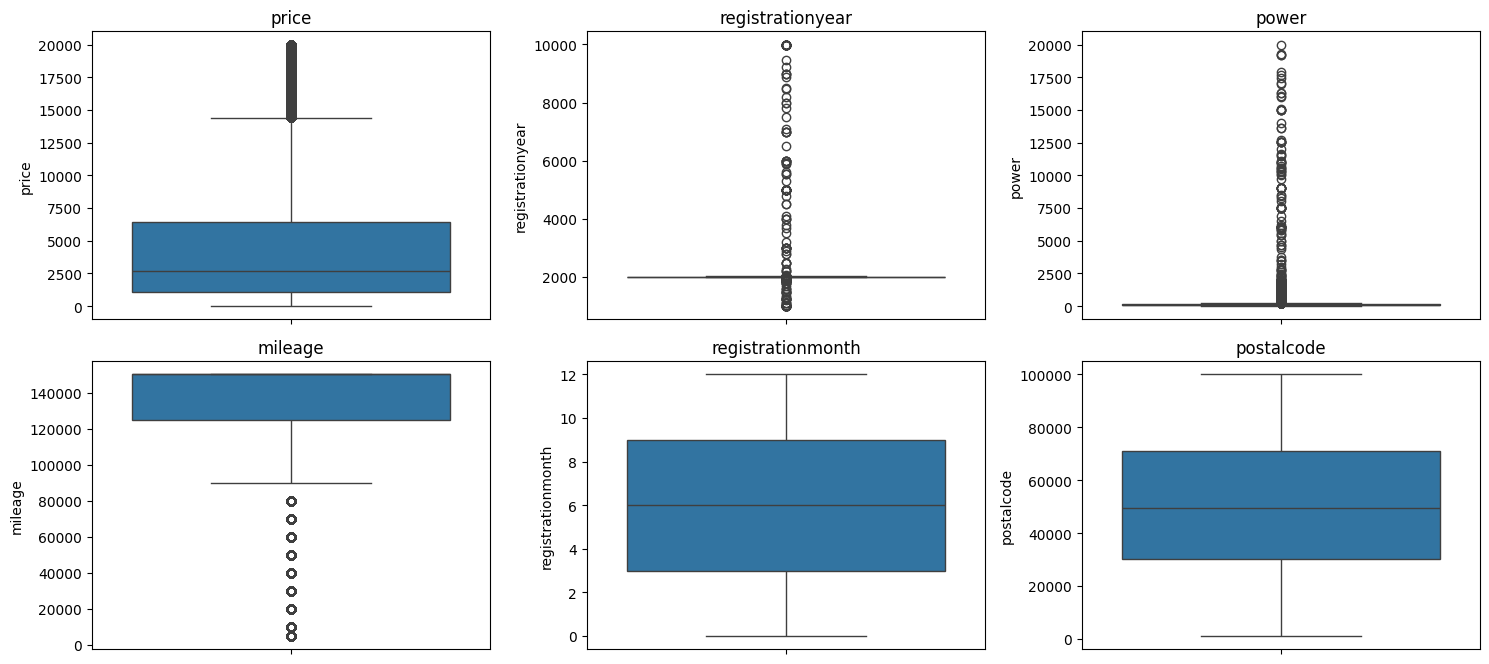

In [31]:
numeric_cols = df.select_dtypes('int64').columns
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10), constrained_layout=True)
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(data=df, y=col, ax=axes[i])
    axes[i].set_title(f'{col}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

In [32]:
def detect_outliers(df):
    outliers_dict = {}
    for col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers_dict[col] = outliers.index
    return outliers_dict

outliers = detect_outliers(df[numeric_cols])
outliers_count = {col: len(outliers[col]) for col in numeric_cols}
outliers_percent = {col: (count / len(df) * 100) for col, count in outliers_count.items()}

#### Outliers e seu peso no modelo

In [33]:
for col, perc in outliers_percent.items():
    print(f'{col}: {perc:.2f}% de dados serão descartados ao remover os outliers')

price: 5.36% de dados serão descartados ao remover os outliers
registrationyear: 1.78% de dados serão descartados ao remover os outliers
power: 2.07% de dados serão descartados ao remover os outliers
mileage: 15.03% de dados serão descartados ao remover os outliers
registrationmonth: 0.00% de dados serão descartados ao remover os outliers
postalcode: 0.00% de dados serão descartados ao remover os outliers


### comparação Km do veiculo vs Preço

Text(0.5, 1.0, 'Mileage vs Price')

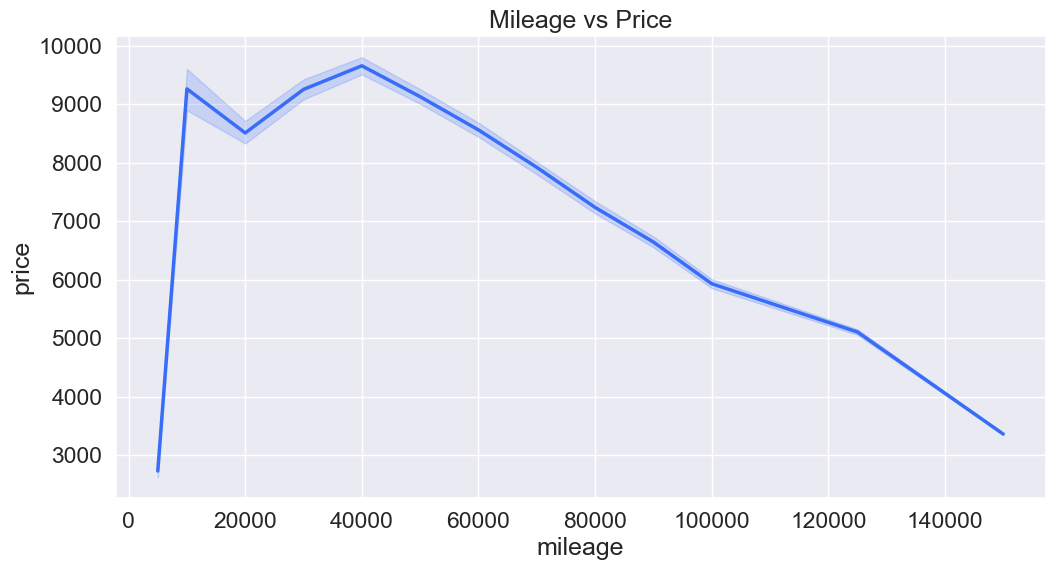

In [34]:
sns.set_style('darkgrid')
# sns.set_context('talk')
sns.set_palette('rainbow')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

plt.figure(figsize=(12, 6))
sns.lineplot(x='mileage', y='price', data=df);
plt.title('Mileage vs Price')

#### Registro do veiculo vs Preço

Text(0.5, 1.0, 'Registration Year vs Price')

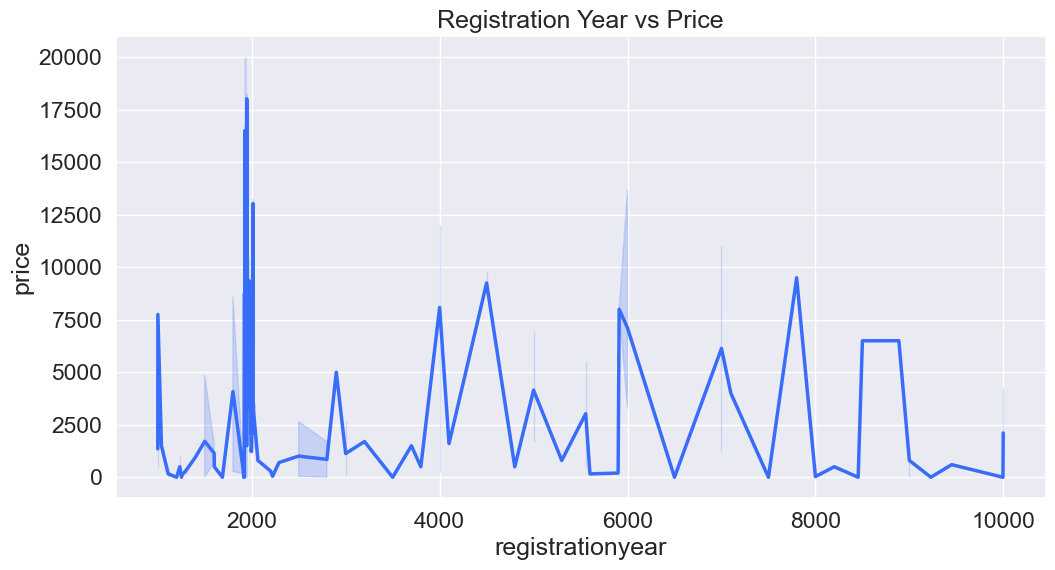

In [35]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='registrationyear', y="price", data=df);
plt.title('Registration Year vs Price')

### Retirando os dados ausentes do dataset


#### Observando a quantidade de linhas dodataset

In [36]:
qtde_df_antigo = len(df)
qtde_df_antigo

354369

#### Excluindo os ausentes

In [37]:
df.dropna(inplace=True)
df

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,datecreated,postalcode,lastseen
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,60437,06/04/2016 10:17
5,04/04/2016 17:36,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,04/04/2016 00:00,33775,06/04/2016 19:17
6,01/04/2016 20:48,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,01/04/2016 00:00,67112,05/04/2016 18:18
7,21/03/2016 18:54,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,21/03/2016 00:00,19348,25/03/2016 16:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354360,02/04/2016 20:37,3999,wagon,2005,manual,3,3er,150000,5,gasoline,bmw,no,02/04/2016 00:00,81825,06/04/2016 20:47
354362,19/03/2016 19:53,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes,19/03/2016 00:00,96465,19/03/2016 20:44
354363,27/03/2016 20:36,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,27/03/2016 00:00,26624,29/03/2016 10:17
354366,05/03/2016 19:56,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,05/03/2016 00:00,26135,11/03/2016 18:17


#### verificando o percentual de perda de dados

In [38]:
(len(df)/qtde_df_antigo)*100

69.36667710776055

#### somando a quantidade de linha que sobraram para o projeto

In [39]:
df['datecrawled'].sum

<bound method Series.sum of 3         17/03/2016 16:54
4         31/03/2016 17:25
5         04/04/2016 17:36
6         01/04/2016 20:48
7         21/03/2016 18:54
                ...       
354360    02/04/2016 20:37
354362    19/03/2016 19:53
354363    27/03/2016 20:36
354366    05/03/2016 19:56
354367    19/03/2016 18:57
Name: datecrawled, Length: 245814, dtype: object>

Mesmo retirando 30% dos dados ainda temos aproximadamente 245 mil linhas para poder trabalhar.

#### Removendo duplicatas

In [40]:
df = df.drop_duplicates()
len(df)/qtde_df_antigo

0.6929697575126492

Foi verificado variação da porcentagem, verificamos que existiam dados duplicados que foram retirados do dataset

#### Onservando dataset apos tratamento

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 245567 entries, 3 to 354367
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        245567 non-null  object
 1   price              245567 non-null  int64 
 2   vehicletype        245567 non-null  object
 3   registrationyear   245567 non-null  int64 
 4   gearbox            245567 non-null  object
 5   power              245567 non-null  int64 
 6   model              245567 non-null  object
 7   mileage            245567 non-null  int64 
 8   registrationmonth  245567 non-null  int64 
 9   fueltype           245567 non-null  object
 10  brand              245567 non-null  object
 11  notrepaired        245567 non-null  object
 12  datecreated        245567 non-null  object
 13  postalcode         245567 non-null  int64 
 14  lastseen           245567 non-null  object
dtypes: int64(6), object(9)
memory usage: 30.0+ MB


## Treinamento do modelo


### utilização de codificação de rótulos para as características 


In [42]:
le = LabelEncoder()
df_scaled = df.apply(le.fit_transform)

In [45]:
feature_names = ['datecrawled','price','vehicletype','registrationyear','gearbox', 'power', 'model',
    'mileage', 'registrationmonth', 'registrationmonth','fueltype', 'brand', 'notrepaired',
    'datecreated', 'postalcode', 'lastseen']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df_scaled[feature_names].to_numpy())

df_scaled = df_scaled.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df_scaled[feature_names].to_numpy())
df_scaled

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,registrationmonth,fueltype,brand,notrepaired,datecreated,postalcode,lastseen
3,0.543444,0.170094,0.714286,0.792683,1,0.139147,0.467742,1.000000,0.500000,0.500000,1.000000,0.973684,0,0.568627,0.863974,0.528414
4,0.987558,0.336663,0.714286,0.878049,1,0.128015,0.407258,0.750000,0.583333,0.583333,0.333333,0.815789,0,1.000000,0.516601,0.203693
5,0.120360,0.079612,0.571429,0.719512,1,0.189239,0.044355,1.000000,0.833333,0.833333,1.000000,0.052632,1,0.127451,0.290015,0.209627
6,0.026844,0.228261,0.142857,0.829268,1,0.202226,0.032258,1.000000,0.666667,0.666667,1.000000,0.657895,0,0.019608,0.569004,0.177497
7,0.671851,0.000000,0.571429,0.536585,1,0.092764,0.669355,0.333333,0.583333,0.583333,1.000000,0.973684,0,0.705882,0.141601,0.787975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354360,0.058760,0.366921,1.000000,0.841463,1,0.005566,0.044355,1.000000,0.416667,0.416667,0.333333,0.052632,0,0.058824,0.726090,0.210886
354362,0.608222,0.306404,0.571429,0.829268,1,0.417440,0.564516,1.000000,0.416667,0.416667,1.000000,0.789474,1,0.647059,0.956269,0.588179
354363,0.865981,0.133079,0.000000,0.780488,1,0.000000,1.000000,1.000000,0.250000,0.250000,1.000000,0.631579,0,0.882353,0.226957,0.907205
354366,0.145919,0.138367,0.142857,0.780488,0,0.187384,0.427419,0.916667,0.250000,0.250000,1.000000,0.842105,0,0.156863,0.222250,0.349059


### Divididndo os dados em treino categoria e teste

In [46]:
X = df.drop(['price', 'datecrawled', 'datecreated', 'postalcode', 'lastseen'], axis = 1).to_numpy()
y = df['price'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

X = ['price']
categoryy = df[X].select_dtypes('object').columns

In [47]:
feature_names = ['vehicletype', 'registrationyear', 'gearbox', 'power', 'model', 'mileage', 'fueltype', 'brand', 'notrepaired']
X = ['price']

CATEGORICAL = df[feature_names].select_dtypes('object').columns

In [48]:
X_train_val, X_test, y_train_val, y_test = train_test_split(df[feature_names], df[X], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

### Encoder

In [49]:
encoder = ce.CatBoostEncoder(cols=CATEGORICAL)
encoder.fit(X_train, y_train)

X_train = encoder.transform(X_train)
X_train_val = encoder.transform(X_train_val)
X_test = encoder.transform(X_test)
X_val = encoder.transform(X_val)



### Ajuste de hyperparametros

In [50]:
def perform_gs(model, param_grid, X, y):
    gs = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=10)
    gs.fit(X, y)
    best_model = gs.best_estimator_
    best_params = gs.best_params_
    best_score = gs.best_score_
    return best_model, best_params, best_score

### Modelo LightGBM


In [51]:
from sklearn.model_selection import GridSearchCV
train_data_scaled = lgb.Dataset(X_train, label=y_train)
test_data_scaled = lgb.Dataset(X_test, label=y_test)

params = {
    'num_leaves': [31,100] ,
    'learning_rate' : [0.01, 0.05],
}

model_hip = lgb.LGBMRegressor()


In [52]:
params_model = {
    'metric': 'rmse',
    'num_leaves' : 31,
    'learning_rate' : 0.05,
}

In [53]:
import lightgbm as lgb
import time

train_data = lgb.Dataset(X_train_val, label=y_train_val)
test_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

start_time = time.time()


model = lgb.train(
    params_model,  # Parâmetros do modelo
    train_data,  # Dados de treino
    valid_sets=[test_data],  # Dados de validação
    num_boost_round=100,  # Número máximo de iterações
    callbacks=[lgb.callback.early_stopping(stopping_rounds=50)]  # Parada antecipada
)

end_time = time.time()
total_time_lgb = end_time - start_time


print(f'Tempo total de treinamento: {total_time_lgb} segundos')



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 656
[LightGBM] [Info] Number of data points in the train set: 196453, number of used features: 9
[LightGBM] [Info] Start training from score 5126.598728
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1745.22
Tempo total de treinamento: 0.3348097801208496 segundos


In [54]:
y_pred_gbm = model.predict(X_test)

In [55]:
rmse_gbm = mean_squared_error(y_test, y_pred_gbm, squared=False)
print(rmse_gbm)

1777.4420392146212


In [56]:
print("Tempo total de execução: {:.2f} segundos".format(total_time_lgb))

Tempo total de execução: 0.33 segundos


### Modelo Floresta Aleatória


#### Calibrando os hiperparâmetros

In [57]:
rf_model = RandomForestRegressor()

param_grid = {
    'n_estimators': [5, 10, 15], 
    'max_depth': [1, 5, 10]
}

In [58]:
rf_grid = GridSearchCV(rf_model, param_grid, cv=5)
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 5, 10], 'n_estimators': [5, 10, 15]})

In [59]:
GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 5, 10], 'n_estimators': [5, 10, 15]})

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 5, 10], 'n_estimators': [5, 10, 15]})

In [60]:
print('Melhores hiperparâmetros: ', rf_grid.best_params_)
print('Melhor pontuação: ', rf_grid.best_score_)

Melhores hiperparâmetros:  {'max_depth': 10, 'n_estimators': 15}
Melhor pontuação:  0.8431935033001297


#### Treinando o modelo

In [61]:
rf = RandomForestRegressor(max_depth = None, n_estimators=20, random_state=12345)
start_time = time.time()

rf.fit(X_train, y_train)
end_time = time.time()
total_time_rf = end_time - start_time

In [62]:
print("Tempo total de execução: {:.2f} segundos".format(total_time_rf))

Tempo total de execução: 6.54 segundos


### Árvore de Decisão

In [63]:
dtr = DecisionTreeRegressor()
param_grid = {
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10]
}

In [64]:
grid_search = GridSearchCV(dtr, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 4, 6, 8, 10],
                         'min_samples_split': [2, 4, 6, 8, 10]})

In [65]:
GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 4, 6, 8, 10],
                         'min_samples_split': [2, 4, 6, 8, 10]})

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 4, 6, 8, 10],
                         'min_samples_split': [2, 4, 6, 8, 10]})

In [66]:
print('Melhores hiperparâmetros:', grid_search.best_params_)
print('Melhor pontuação:', grid_search.best_score_)

Melhores hiperparâmetros: {'max_depth': 10, 'min_samples_split': 8}
Melhor pontuação: 0.8225026552177341


### Treinando o modelo

In [67]:
dtr = DecisionTreeRegressor(max_depth = 10, min_samples_split = 10, random_state=12345)

start_time = time.time()
dtr.fit(X_train, y_train)
end_time = time.time()
total_time_dtr = end_time - start_time

In [68]:
y_pred_dtr = dtr.predict(X_test)

In [69]:
rmse_dtr = mean_squared_error(y_test, y_pred_dtr, squared=False)
rmse_dtr

1958.7487432604446

In [70]:
print("Tempo total de execução: {:.2f} segundos".format(total_time_dtr))

Tempo total de execução: 0.21 segundos


### Modelo Regressão Linear


In [71]:
rl = LinearRegression()

start_time = time.time()
rl.fit(X_train, y_train)
end_time = time.time()
total_time_rl = end_time - start_time

In [72]:
y_pred_rl = rl.predict(X_test)

In [73]:
rmse_rl = mean_squared_error(y_test, y_pred_rl, squared=False)
rmse_rl
print(rmse_rl)

2989.1059179326676


In [74]:
lr = LinearRegression()
lr.fit(X_train_val, y_train_val)
lr_pred = lr.predict(X_val)

In [75]:
rmse_rl = mean_squared_error(y_test, y_pred_rl) ** 0.5
rmse_rl

2989.1059179326676

In [76]:
print("Tempo total de execução: {:.2f} segundos".format(total_time_rl))

Tempo total de execução: 0.05 segundos


In [77]:
from sklearn.metrics import mean_squared_error
import numpy as np


def rmse(y, a):
    return np.sqrt(mean_squared_error(y, a))

# Cálculo dos valores de RMSE para diferentes modelos
rmse_rl = rmse(y_test, y_pred_rl)  # Para o modelo de regressão linear 
rmse_dtr = rmse(y_test, y_pred_dtr)  # Para o modelo de árvore de decisão 
rmse_gbm = rmse(y_test, y_pred_gbm)  # Para o modelo GBM 

# Exibindo os resultados

print("Erro Quadrático Médio  para Regressão Linear:", rmse_rl)
print("Erro Quadrático Médio  para Árvore de Decisão:", rmse_dtr)
print("Erro Quadrático Médio  para GBM:", rmse_gbm)



Erro Quadrático Médio  para Regressão Linear: 2989.1059179326676
Erro Quadrático Médio  para Árvore de Decisão: 1958.7487432604446
Erro Quadrático Médio  para GBM: 1777.4420392146212


### Análise do modelo


Neste projeto, utilizamos os modelos LightGBM, Floresta Aleatória, Árvore de Decisão e Regressão Linear para determinar o melhor ajuste ao nosso conjunto de dados. Testamos diferentes parâmetros no modelo LightGBM, o que impactou significativamente o tempo de execução. Por esse motivo, optamos por manter as configurações utilizadas no projeto. Além de medir o tempo de execução de cada modelo, avaliamos todos eles com base no RMSE (Erro Quadrático Médio da Raiz). Assim, escolhemos o modelo LightGBM como o mais adequado para a tarefa, pois, apesar de ter o maior tempo de execução, ele apresenta um desempenho aceitável.